# Stanford 40
### Download the data
You can see the zip files if you click the Files tab (looks like a folder symbol on the left of the screen)

In [ ]:
!wget http://vision.stanford.edu/Datasets/Stanford40_JPEGImages.zip
!wget http://vision.stanford.edu/Datasets/Stanford40_ImageSplits.zip

### Unzip it

In [ ]:
!unzip Stanford40_JPEGImages.zip -d Stanford40/
!unzip Stanford40_ImageSplits.zip -d Stanford40/

## Read the train and test splits, combine them and make better splits to help training networks easier.

In [ ]:
from collections import Counter
from sklearn.model_selection import train_test_split

keep_stanford40 = ["applauding", "climbing", "drinking", "jumping", "pouring_liquid", "riding_a_bike", "riding_a_horse", 
        "running", "shooting_an_arrow", "smoking", "throwing_frisby", "waving_hands"]
with open('Stanford40/ImageSplits/train.txt', 'r') as f:
    # We won't use these splits but split them ourselves
    train_files = [file_name for file_name in list(map(str.strip, f.readlines())) if '_'.join(file_name.split('_')[:-1]) in keep_stanford40]
    train_labels = ['_'.join(name.split('_')[:-1]) for name in train_files]

with open('Stanford40/ImageSplits/test.txt', 'r') as f:
    # We won't use these splits but split them ourselves
    test_files = [file_name for file_name in list(map(str.strip, f.readlines())) if '_'.join(file_name.split('_')[:-1]) in keep_stanford40]
    test_labels = ['_'.join(name.split('_')[:-1]) for name in test_files]

# Combine the splits and split for keeping more images in the training set than the test set.
all_files = train_files + test_files
all_labels = train_labels + test_labels
train_files, test_files = train_test_split(all_files, test_size=0.1,random_state=0, stratify=all_labels)
train_labels = ['_'.join(name.split('_')[:-1]) for name in train_files]
test_labels = ['_'.join(name.split('_')[:-1]) for name in test_files]
print(f'Train files ({len(train_files)}):\n\t{train_files}')
print(f'Train labels ({len(train_labels)}):\n\t{train_labels}\n'\
      f'Train Distribution:{list(Counter(sorted(train_labels)).items())}\n')
print(f'Test files ({len(test_files)}):\n\t{test_files}')
print(f'Test labels ({len(test_labels)}):\n\t{test_labels}\n'\
      f'Test Distribution:{list(Counter(sorted(test_labels)).items())}\n')
action_categories = sorted(list(set(train_labels)))
print(f'Action categories ({len(action_categories)}):\n{action_categories}')

Train files (2733):
	['drinking_203.jpg', 'smoking_048.jpg', 'running_099.jpg', 'jumping_186.jpg', 'smoking_205.jpg', 'riding_a_bike_090.jpg', 'climbing_184.jpg', 'throwing_frisby_078.jpg', 'applauding_185.jpg', 'throwing_frisby_131.jpg', 'running_241.jpg', 'riding_a_horse_229.jpg', 'throwing_frisby_009.jpg', 'climbing_126.jpg', 'waving_hands_188.jpg', 'shooting_an_arrow_062.jpg', 'riding_a_horse_191.jpg', 'applauding_087.jpg', 'applauding_074.jpg', 'riding_a_bike_181.jpg', 'running_091.jpg', 'riding_a_bike_188.jpg', 'riding_a_bike_027.jpg', 'throwing_frisby_035.jpg', 'climbing_022.jpg', 'applauding_095.jpg', 'waving_hands_024.jpg', 'running_225.jpg', 'climbing_224.jpg', 'riding_a_bike_108.jpg', 'running_050.jpg', 'jumping_089.jpg', 'pouring_liquid_089.jpg', 'climbing_087.jpg', 'applauding_143.jpg', 'jumping_069.jpg', 'waving_hands_039.jpg', 'smoking_019.jpg', 'drinking_030.jpg', 'running_189.jpg', 'climbing_159.jpg', 'climbing_221.jpg', 'drinking_162.jpg', 'drinking_210.jpg', 'riding_

### Visualize a photo from the training files and also print its label

An image with the label - drinking


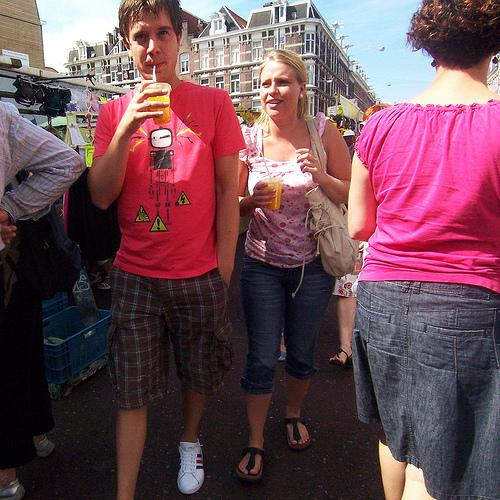

In [ ]:
import cv2
from google.colab.patches import cv2_imshow

image_no = 234  # change this to a number between [0, 1200] and you can see a different training image
img = cv2.imread(f'Stanford40/JPEGImages/{train_files[image_no]}')
print(f'An image with the label - {train_labels[image_no]}')
cv2_imshow(img)

# Human Motion Database 51 (HMDB51)
### Download the dataset

In [ ]:
!pip install av
! wget https://raw.githubusercontent.com/pytorch/vision/6de158c473b83cf43344a0651d7c01128c7850e6/references/video_classification/transforms.py
# Download HMDB51 data and splits from serre lab website
! wget http://serre-lab.clps.brown.edu/wp-content/uploads/2013/10/hmdb51_org.rar
! wget http://serre-lab.clps.brown.edu/wp-content/uploads/2013/10/test_train_splits.rar

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.2/31.2 MB 33.1 MB/s eta 0:00:00
--2023-03-27 12:41:21--  https://raw.githubusercontent.com/pytorch/vision/6de158c473b83cf43344a0651d7c01128c7850e6/references/video_classification/transforms.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3102 (3.0K) [text/plain]
Saving to: ‘transforms.py’

transforms.py       100%[===================>]   3.03K  --.-KB/s    in 0s      

2023-03-27 12:41:21 (36.6 MB/s) - ‘transforms.py’ saved [3102/3102]

--2023-03-27 12:41:22--  http://serre-lab.clps.brown.edu/wp-content/uploads/2013/10/hmdb51_org.rar
Resolving serre-lab.clps.brown.edu (serre-lab.clps.brown.edu)... 128.148.254.

# Extract and organize the data.

In [ ]:
! mkdir -p video_data test_train_splits
! unrar e test_train_splits.rar test_train_splits
! rm test_train_splits.rar
! unrar e hmdb51_org.rar 
! rm hmdb51_org.rar
! mv *.rar video_data
import os
keep_hmdb51 = ["clap", "climb", "drink", "jump", "pour", "ride_bike", "ride_horse", 
        "run", "shoot_bow", "smoke", "throw", "wave"]
for files in os.listdir('video_data'):
    foldername = files.split('.')[0]
    if foldername in keep_hmdb51:
      # extract only the relevant classes for the assignment.
      os.system("mkdir -p video_data/" + foldername)
      os.system("unrar e video_data/"+ files + " video_data/"+foldername)

! rm video_data/*.rar


# Load data into dataloaders with necessary transforms

In [ ]:
import torchvision
import torch.nn.functional as F
import torchvision.transforms as transforms
import torch.optim as optim
from torch.utils.data import random_split, DataLoader
import torch
import transforms as T

torch.manual_seed(97)
num_frames = 16
clip_steps = 2
batch_size = 16

transform = transforms.Compose([ T.ToFloatTensorInZeroOne(),
                                 T.Resize((200, 200)),
                                 T.RandomCrop((172, 172))])
transform_test = transforms.Compose([                           
                                 T.ToFloatTensorInZeroOne(),
                                 T.Resize((200, 200)),
                                 T.CenterCrop((172, 172))])


hmdb51_train = torchvision.datasets.HMDB51('video_data/', 'test_train_splits/', num_frames, frame_rate=5,
                                                step_between_clips = clip_steps, fold=1, train=True,
                                                transform=transform, num_workers=2)

hmdb51_test = torchvision.datasets.HMDB51('video_data/', 'test_train_splits/', num_frames, frame_rate=5,
                                                step_between_clips = clip_steps, fold=1, train=False,
                                                transform=transform_test, num_workers=2)

train_loader = DataLoader(hmdb51_train, batch_size=batch_size, shuffle=True)
test_loader  = DataLoader(hmdb51_test, batch_size=batch_size, shuffle=False)

  0%|          | 0/97 [00:00<?, ?it/s]

/usr/local/lib/python3.9/dist-packages/torchvision/datasets/video_utils.py:219: UserWarning: There aren't enough frames in the current video to get a clip for the given clip length and frames between clips. The video (and potentially others) will be skipped.
  warnings.warn(


  0%|          | 0/97 [00:00<?, ?it/s]

# Let's print the data shape with batch size 16 and 16 frames.

In [ ]:
for data, _, labels in train_loader:
  print(data.shape)  # 16-batch size, 3-channels, 16-frames, 172x172-crop
  print(labels)  # 12 classes [0-11]
  break

/usr/local/lib/python3.9/dist-packages/torchvision/io/video.py:162: UserWarning: The pts_unit 'pts' gives wrong results. Please use pts_unit 'sec'.
  warnings.warn("The pts_unit 'pts' gives wrong results. Please use pts_unit 'sec'.")


torch.Size([16, 3, 16, 172, 172])
tensor([11,  8,  9,  8,  4,  8,  1,  6,  4,  8,  4,  9,  4,  8,  1,  4])
